<a href="https://colab.research.google.com/github/Nandit12/Instance-Segmentation/blob/master/inst_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

In [3]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 178090079/178090079 [00:01<00:00, 96477152.11it/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [0]:
def random_colour_masks(image):
    """
    random_colour_masks
    parameters:
     - image - predicted masks
    method:
     - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
def get_prediction(img_path, threshold):
    """
    get_prediction
    parameters:
     - img_path - path of the input image
    method:
     - Image is obtained from the image path
     - the image is converted to image tensor using PyTorch's Transforms
     - image is passed through the model to get the predictions
     - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
     ie: eg. segment of cat is made 1 and rest of the image is made 0

    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

In [0]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    """
    instance_segmentation_api
    parameters:
     - img_path - path to input image
    method:
     - prediction is obtained by get_prediction
     - each mask is given random color
     - each mask is added to the image in the ratio 1:0.8 with opencv
     - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]

In [9]:
from google.colab import files

uploaded = files.upload()

##files.upload returns a dictionary of the files which were uploaded. The 
##dictionary is keyed by the file name, the value is the data which was 
##uploaded.

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bill-gates-africa.jpg to bill-gates-africa.jpg
User uploaded file "bill-gates-africa.jpg" with length 2907768 bytes


In [0]:
img = Image.open('./bill-gates-africa.jpg')
transform = T.Compose([T.ToTensor()])
img = transform(img)
pred = model([img])

In [11]:
pred[0]

{'boxes': tensor([[ 123.2708,   97.0473, 3112.0837, 2468.0745],
         [1367.7792, 2179.6343, 1653.8173, 2478.8135]], grad_fn=<StackBackward>),
 'labels': tensor([ 1, 32]),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>),
 'scores': tensor([0.9984, 0.9977], grad_fn=<IndexBackward>)}

In [12]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(2, 2483, 3789)

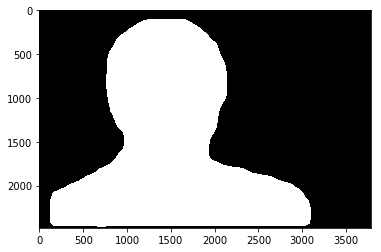

In [13]:
plt.imshow(masks[0], cmap='gray')
plt.show()

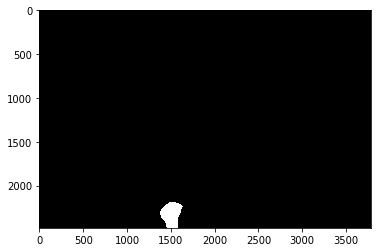

In [14]:
plt.imshow(masks[1], cmap='gray') 
plt.show()

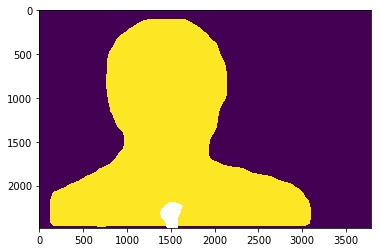

In [15]:
import numpy.ma as ma

combined_masks = ma.masked_array(masks[0] > 0, masks[1])
plt.imshow(combined_masks)
plt.show()

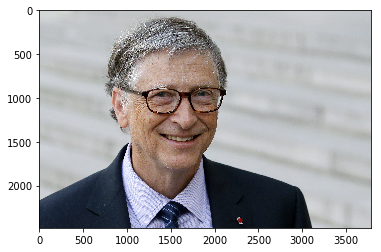

In [16]:
import matplotlib.image as mpimg
img=mpimg.imread('./bill-gates-africa.jpg')
plt.imshow(img)
plt.show()

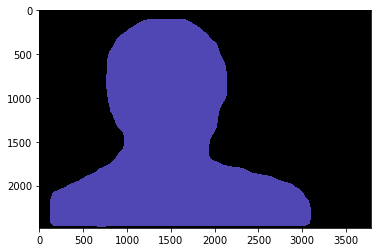

In [17]:
mask1 = random_colour_masks(masks[0])
mask2 = random_colour_masks(masks[1])
plt.imshow(mask1); plt.show()

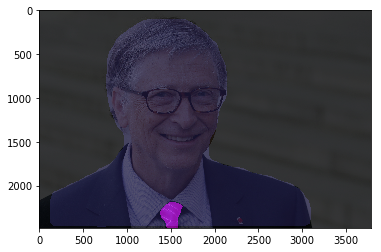

In [18]:
masked1 = cv2.addWeighted(img, 0.5, mask1, 0.5, 0)
masked2 = cv2.addWeighted(masked1, 0.5, mask2, 0.5, 0)

plt.imshow(masked2)

--2019-07-09 09:08:43--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2307387 (2.2M) [image/jpeg]
Saving to: ‘mrcnn_cars.jpg’

mrcnn_cars.jpg      100%[===================>]   2.20M  --.-KB/s    in 0.07s   

2019-07-09 09:08:43 (29.4 MB/s) - ‘mrcnn_cars.jpg’ saved [2307387/2307387]



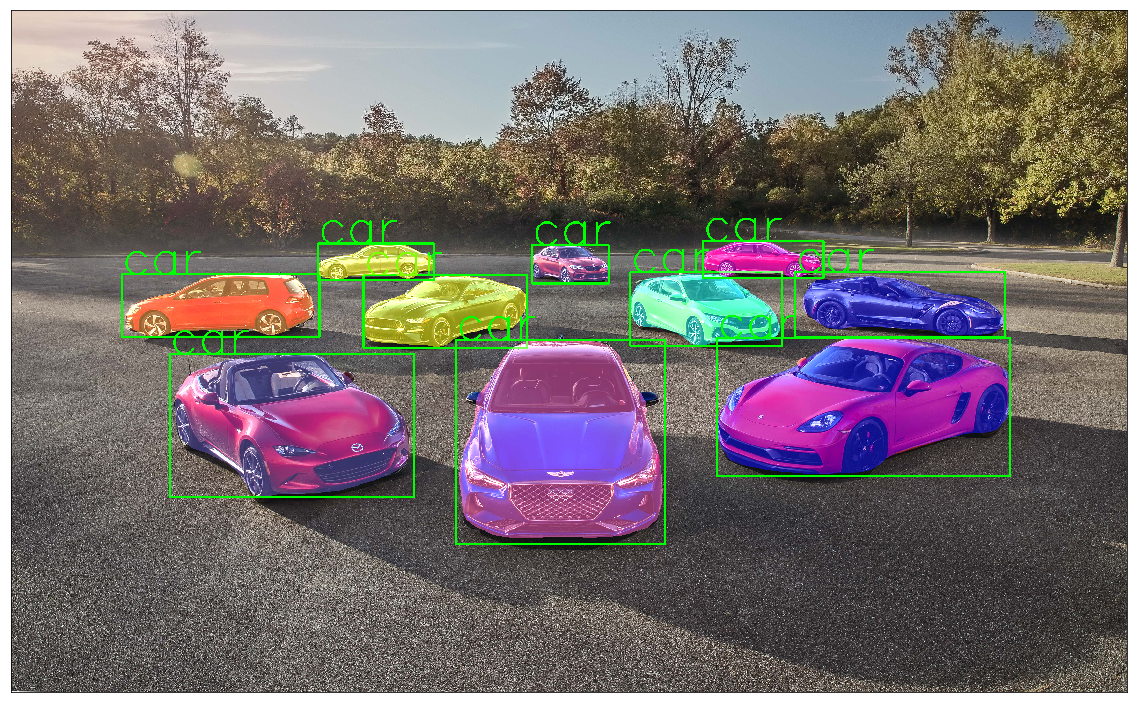

In [19]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O mrcnn_cars.jpg
instance_segmentation_api('./mrcnn_cars.jpg', 0.9, rect_th=5, text_size=5, text_th=5)

In [24]:
from google.colab import files

uploaded = files.upload()

##files.upload returns a dictionary of the files which were uploaded. The 
##dictionary is keyed by the file name, the value is the data which was 
##uploaded.

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cars.jpg to cars (3).jpg


KeyboardInterrupt: ignored

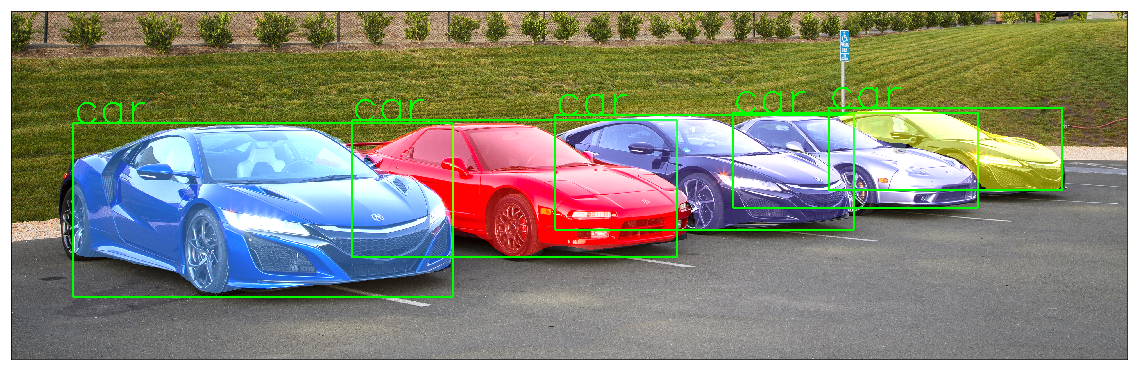

In [25]:
instance_segmentation_api('./cars (1).jpg', 0.9, rect_th=5, text_size=5, text_th=5)

In [0]:
import time

def check_inference_time(image_path, gpu=False):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  model.eval()
  img = Image.open(image_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  if gpu:
    model.cuda()
    img = img.cuda()
  else:
    model.cpu()
    img = img.cpu()
  start_time = time.time()
  pred = model([img])
  end_time = time.time()
  return end_time-start_time

In [26]:

cpu_time = sum([check_inference_time('./cars (1).jpg', gpu=False) for _ in range(5)])/5.0
gpu_time = sum([check_inference_time('./cars (1).jpg', gpu=True) for _ in range(5)])/5.0


print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))



Average Time take by the model with GPU = 0.17741479873657226s
Average Time take by the model with CPU = 5.092975330352783s
